In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from tqdm.notebook import tqdm
from pathlib import Path
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchtext

import timm
import fastai.text.all as fastai
from fastai.callback.schedule import Learner

# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
%load_ext tensorboard

import spacy
import re
import nltk

seed = 42
np.random.seed(seed + 1)
torch.manual_seed(seed)

nlp = spacy.load("en_core_web_sm")

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'
    return device

device = get_device()

print(f'device: {device}')

device: cuda


In [3]:
def get_optimizer(model, optimizer='sgd', lr=0.001, weight_decay=0, momentum=0, betas=(0.9, 0.999), eps=1e-8):
    if optimizer == 'sgd':
        opt = torch.optim.SGD(
            model.parameters(),
            lr=lr, 
            weight_decay=weight_decay, 
            momentum=momentum
        )
    if optimizer == 'adam':
        opt = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=betas,
            eps=eps
        )
    return opt

def train_model(train_data, model, opt, loss_fn, test_data=None, num_epochs=10, plot_loss=True, batch_size=32,
               tensorboard=False, print_stats=True, show_batches_bar=False, shuffle=True, scheduler=None,
               print_every=1, n_grad_accums=1, use_multi_gpus=False):
    if tensorboard:
        writer = SummaryWriter()
    losses = []
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    if test_data is not None:
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    if use_multi_gpus:
        orig_model = model
        model = nn.DataParallel(model)
    for epoch in tqdm(range(num_epochs)):
        model = model.train()
        batch_losses = []
        batch_correct = []
        iterator = tqdm(train_loader, leave=False) if show_batches_bar else train_loader
        for i, (X, y) in enumerate(iterator):
            X = X.to(device)
            y = y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y).mean() # mean is for multi-gpu losses, avg them together
            loss /= n_grad_accums # rescale loss for grad accumulation
            loss.backward()
            if i % n_grad_accums == 0: # only step when every n_grad_accums grad updates
                opt.step()
                opt.zero_grad()
            batch_losses.append(float(loss)* batch_size)
            batch_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
        train_loss = sum(batch_losses) / len(train_data)
        train_acc = sum(batch_correct) / len(train_data)
        losses.append(train_loss)
        
        if test_data is not None:
            model = model.eval()
            opt.zero_grad()
            batch_losses = []
            batch_correct = []
            iterator = tqdm(test_loader, leave=False) if show_batches_bar else test_loader
            for X, y in iterator:
                X = X.to(device)
                y = y.to(device)
                yhat = model(X)
                loss = loss_fn(yhat, y).mean()
                batch_losses.append(float(loss) * batch_size)
                batch_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
            test_loss = sum(batch_losses) / len(test_data)
            test_acc = sum(batch_correct) / len(test_data)
        else:
            test_loss = -999
            test_acc = -999
            
        if scheduler is not None:
            scheduler.step()

        if tensorboard:
            writer.add_scalar("Training Loss", train_loss, epoch+1)
            writer.add_scalar("Training Accuracy", train_acc, epoch+1)
            writer.add_scalar("Test Loss", test_loss, epoch+1)
            writer.add_scalar("Test Accuracy", test_acc, epoch+1)
        if print_stats and epoch % print_every == 0:
            s1 = f'epoch: {epoch: <3}   ' 
            s2 = f'train loss: {round(train_loss, 4): <6}   train acc: {round(train_acc, 4): <6}   ' 
            s3 = f'test loss: {round(test_loss, 4): <6}   test acc: {round(test_acc, 4): <6}'
            print(s1 + s2 + s3)
    if plot_loss:
        plt.plot(range(len(losses)), losses)
        plt.show()
    if tensorboard:
        writer.flush()
        writer.close()
    model = model if not use_multi_gpus else orig_model
    return model

class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Recurrent Neural Networks (RNNs)

- Neural network used to learn input/output relationships for examples that have some kind of sequential, temporal relationship. Allows the network to use learned shared features to take into account the context (sequence order) of a given example.
- Maps a temporal sequence $x_1,\cdots,x_T$ to another temporal sequence $y_1,\cdots,y_{T'}$ by learning a function of past and present input values: $y_t = f_t(x_1,\cdots,x_t)$.
- Each $x = (x_1,\cdots,x_T) \rightarrow y = (y_1,\cdots,y_{T'})$ pair becomes a "training example" in a sense. The output of an RNN layer for a particular sequence element $t=1,\cdots,T$ is given by
$$ h_t = \tanh(W_{xh} x_t + b_{xh} + W_{hh} h_{t-1} + b_{hh}),$$
$$ \hat y_t = \sigma(W_{hy} h_t + b_{hy}).$$
- One needs to initialize $h_0$ to have some value. One can use zeros, a random initialization, or (for a stateful RNN) use the output $h_0 \equiv h_T^{prev}$ from the previous batch.
- Typically the tanh function is used for hidden activation function in RNNs instead of the ReLU.
- Input and output sequences need not have the same length, nor need one or the other be a sequence at all.
- Each unit of the RNN has an input state, hidden state, and output state. All params are shared across all elements in the sequence, so only $x_t, h_t$ contain information about position.
- Typically $T, T'$ are not actually the length of the input/output sequences, but a defined sequence length. This means each sequence gets split into $k$ chunks of length $T$, potentially breaking the ordering between those chunks.
- For sequences of size less than $T,T'$, padding the input/output with `<PAD>` tokens can be used to fill in the gaps.
- The standard RNN is only unidirectional. Sequences read left to right. To take advantage of "acausal" sequence information, one can use a bidirectional RNN (BiRNN) that uses both left-to-right and right-to-left hidden units.
- The loss in an RNN is the sum of the output losses: 
$$L(y,\hat y) = L_1(y_1,\hat y_1) + \cdots + L_{T'}(y_{T'},\hat y_{T'}).$$
- Backpropagation on an RNN layer is done "through time" (BPTT). BPTT works by starting at $y_{T'}$ and backpropagating backwards through time all the way to $x_1$. Since the $W_t$ gradient $\frac{\partial L}{\partial W_t} \propto W_{t+1} \dots W_T$, RNNs with long sequence lengths are vulnerable to gradient vanishing. This makes it hard for items in long sequences that are far apart from each other to influence each other.
- For sequence classification tasks, e.g. sentiment classification, one has $T'=1$. To use the full context of the sequence, one typically puts the "useful" classification vector last in the $x_T$ line. Such RNNs are "many-to-one". When $T,T'>1$ the RNN is typically called "many-to-many" or "seq2seq". When $T=1$ but $T'>1$ the RNN is called "one-to-many"; these show up for example in sequence generation tasks.
- Encoder-decoder architectures are also possible for many-to-many RNNs. These are used in applications like machine translation. In this scenario, the inputs are fed into an encoder half that outputs nothing. The encoder feeds its hidden units into a decoder that inputs nothing, but outputs the output sequence. Typically in these, the output $\hat y_{t-1}$ is fed as an effective input into $x_t \equiv \hat y_{t-1}$.
- In PyTorch, sequences are typically fed into RNNs with the order: `(sequence_length, batch_size, num_features)`.

In [4]:
class RNNLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, 
                 hidden_activation=torch.tanh, output_activation=lambda x: x):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.linear_in = nn.Linear(self.input_size, self.hidden_size)
        self.linear_hidden = nn.Linear(self.hidden_size, self.hidden_size)
        self.linear_out = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, x, h=None):
        seq_len, batch_size = x.shape[0], x.shape[1]
        hidden_shape = (1, batch_size, self.hidden_size)
        output_shape = (seq_len, batch_size, self.output_size)
        h = torch.zeros(hidden_shape) if h is None else h
        yhat = torch.zeros(output_shape)
        for t in range(seq_len):
            h = self.hidden_activation(self.linear_in(x[t]) + self.linear_hidden(h))
            yhat[t] = self.output_activation(self.linear_out(h))
        return yhat, h

In [4]:
rnn = RNNLayer(10, 15, 20, torch.tanh, torch.sigmoid) # input_size, hidden_size, output_size
x = torch.randn(5, 3, 10) # seq_len, batch_size, input_size
h0 = torch.zeros(1, 3, 15) # num_layers, batch_size, hidden_size
yhat, h = rnn(x, h0)
x.shape, h.shape, yhat.shape

(torch.Size([5, 3, 10]), torch.Size([1, 3, 15]), torch.Size([5, 3, 20]))

In [5]:
rnn = nn.RNN(10, 20, 1) # input_size, hidden_size, num_layers
x = torch.randn(5, 3, 10) # seq_len, batch_size, input_size
h0 = torch.zeros(1, 3, 20) # num_layers, batch_size, hidden_size
yhat, h = rnn(x, h0)
x.shape, h.shape, yhat.shape

(torch.Size([5, 3, 10]), torch.Size([1, 3, 20]), torch.Size([5, 3, 20]))

## Modified RNNs

The simple RNN is highly susceptible to gradient vanishing/explosion, making it difficult to learn long range dependencies in sequences. To get around this and enable longer sequences, typically one modifies RNNs slightly by adding "gates" to each computation cell, which in reality are just more parameters in the $x_t \rightarrow y_t$ mappings.

**GRUs:** Uses a "relevance" gate $r_t$ and an "update" gate $u_t$. Informally, the relevance gate decides whether the hidden cell should be updated in response to the previous cell, and the update gate weights how much the new cell is important relative to previous cells via a weighted average.
$$\color{red}{u_t = \sigma(W_{uu}u_{t-1} + b_{uu} + W_{xu}x_t + b_{xu})}$$
$$\color{red}{r_t = \sigma(W_{rr}r_{t-1} + b_{rr} + W_{xr}x_t + b_{xr})}$$
$$\tilde h_t = \tanh(W_{hh}(\color{red}{r_t \ast} h_{t-1}) + b_{hh} + W_{xh}x_t + b_{xh})$$
$$h_t = \color{red}{u_t \ast} \tilde h_t \color{red}{+ (1-u_t) \ast h_{t-1}}$$
$$\hat y_t = \sigma(W_{hy} h_t + b_{hy}).$$

In [81]:
rnn = nn.GRU(10, 20, 1) # input_size, hidden_size, num_layers
x = torch.randn(5, 3, 10) # seq_len, batch_size, input_size
h0 = torch.zeros(1, 3, 20) # num_layers, batch_size, hidden_size
yhat, h = rnn(x, h0)
x.shape, h.shape, yhat.shape

(torch.Size([5, 3, 10]), torch.Size([1, 3, 20]), torch.Size([5, 3, 20]))

**LSTMs:** Uses 3 gates, an "update" gate $i_t$, a "forget" gate $f_t$, and an "output" gate $o_t$. Informally, the update gate decides how important the new hidden cell is, the forget gate decides how much of the previous cell to forget, and the output cell decides how relevant the hidden cell is to the output $h_t$.
$$\color{red}{i_t = \sigma(W_{ii}i_{t-1} + b_{ii} + W_{xi}x_t + b_{xi})}$$
$$\color{red}{f_t = \sigma(W_{ff}f_{t-1} + b_{ff} + W_{xf}x_t + b_{xf})}$$
$$\color{red}{o_t = \sigma(W_{oo}o_{t-1} + b_{oo} + W_{xo}x_t + b_{xo})}$$
$$\tilde c_t = \tanh(W_{cc} \color{red}{h_{t-1}} + b_{cc} + W_{xc}x_t + b_{xc})$$
$$c_t = \color{red}{i_t \ast} \tilde c_t + \color{red}{f_t \ast c_{t-1}}$$
$$h_t = \color{red}{o_t \ast \tanh(}c_t\color{red}{)}$$
$$ \hat y_t = \sigma(W_{hy} \color{red}{h_t} + b_{hy}).$$

In [83]:
rnn = nn.LSTM(10, 20, 1) # input_size, hidden_size, num_layers
x = torch.randn(5, 3, 10) # seq_len, batch_size, input_size
c0 = torch.zeros(1, 3, 20) # num_layers, batch_size, hidden_size
h0 = torch.zeros(1, 3, 20) # num_layers, batch_size, hidden_size
yhat, (h, c) = rnn(x, (h0, c0))
x.shape, h.shape, c.shape, yhat.shape

(torch.Size([5, 3, 10]),
 torch.Size([1, 3, 20]),
 torch.Size([1, 3, 20]),
 torch.Size([5, 3, 20]))

**Bidirectional RNNs (BiRNNs):** Regular RNNs are "causal", meaning $\hat y_t$ is only a function or *past inputs* $x_1,\cdots,x_{t-1}$. To allow RNNs to be "acausal", one can use BiRNNs, which use hidden activations in both the past and future directions, $h_t$ and $j_t$. One then combines them at the end to get the output predictions.

$$
h_t = \tanh(W_{xh} x_t + b_{xh} + W_{hh} h_{t-1} + b_{hh}) \\
\color{red}{j_t = \tanh(W_{xj} x_t + b_{xj} + W_{jj} j_{t+1} + b_{jj})} \\
\hat y_t = \sigma(W_{hy} h_t + b_{hy} \color{red}{+ W_{j y} j_t + b_{j y}}).
$$

The downside of a BiRNN is that predictions can't be made in real time. One must wait on the whole sequence to get a prediction even for $t=1$. They are commonly used in NLP, where knowing "both sides" of a sentence can make sense when predicting from text.

In [88]:
rnn = nn.RNN(10, 20, 1, bidirectional=True) # input_size, hidden_size, num_layers
x = torch.randn(5, 3, 10) # seq_len, batch_size, input_size
hj0 = torch.zeros(2, 3, 20) # 2 * num_layers, batch_size, hidden_size
yhat, hj = rnn(x, hj0)
h, j = hj[0][None, :], hj[1][None, :]
x.shape, hj.shape, h.shape, j.shape, yhat.shape

(torch.Size([5, 3, 10]),
 torch.Size([2, 3, 20]),
 torch.Size([1, 3, 20]),
 torch.Size([1, 3, 20]),
 torch.Size([5, 3, 40]))

**Deep RNNs (DRNNs):** RNNs can be stacked in succession to form layers, as with MLPs. The output of one layer gets fed into the next layer, in succession. Deep RNNs can be useful for more complex sequence prediction tasks.

In [91]:
nn.RNN(10, 20, 3) # input_size, hidden_size, num_layers
x = torch.randn(5, 3, 10) # seq_len, batch_size, input_size
h0 = torch.zeros(2, 3, 20) # num_layers, batch_size, hidden_size
yhat, h = rnn(x, h0)
x.shape, h.shape, yhat.shape

(torch.Size([5, 3, 10]), torch.Size([2, 3, 20]), torch.Size([5, 3, 40]))

# Text Processing Review

In [218]:
orig = """
 As the Nameless officially do not exist , the upper echelons of the Gallian Army exploit the concept of plausible 
 deniability in order to send them on missions that would otherwise make Gallia lose face in the war . While at times 
 this works to their advantage , such as a successful incursion into Imperial territory , other orders cause certain 
 members of the 422nd great distress . One such member , John , becomes so enraged that he abandons his post and 
 defects into the ranks of Calamity Raven , attached to the ideal of Darcsen independence proposed by their leader , 
 Dahau . At the same time , elements within Gallian Army Command move to erase the Nameless in order to protect their 
 own interests . Feared by both allies and enemies , and combined with the presence of a traitor within their ranks , 
 the 422nd desperately move to keep themselves alive while at the same time fight to help the Gallian war effort . 
 This continues until the Nameless 's commanding officer , Ramsey Crowe , who had been kept under house arrest , is 
 escorted to the capital city of Bath in order to present evidence hated the weary soldiers and expose the real 
 traitor , the Gallian General that had accused Kurt of Treason .
"""

corpus = [doc.strip() for doc in orig.split('.') if len(doc.strip()) > 0]
labels = [len(doc) for doc in corpus]

len(corpus), len(labels), labels, corpus

(6,
 6,
 [215, 170, 199, 124, 214, 292],
 ['As the Nameless officially do not exist , the upper echelons of the Gallian Army exploit the concept of plausible \n deniability in order to send them on missions that would otherwise make Gallia lose face in the war',
  'While at times \n this works to their advantage , such as a successful incursion into Imperial territory , other orders cause certain \n members of the 422nd great distress',
  'One such member , John , becomes so enraged that he abandons his post and \n defects into the ranks of Calamity Raven , attached to the ideal of Darcsen independence proposed by their leader , \n Dahau',
  'At the same time , elements within Gallian Army Command move to erase the Nameless in order to protect their \n own interests',
  'Feared by both allies and enemies , and combined with the presence of a traitor within their ranks , \n the 422nd desperately move to keep themselves alive while at the same time fight to help the Gallian war effort',


In [227]:
def sub_special_tokens(text):
    # put xxup token before words in all caps (easy way to recognize info from capitalizing a word)
    text = re.sub(r'(\b[A-Z][A-Z0-9]*\b)', r' xxup \1 ', text)
    # put xxcap token before words with capitalized first letter (easy way to recognize first word in a sentence)
    text = re.sub(r'(\b[A-Z][a-z0-9]+\b)', r' xxcap \1 ', text)
    # insert beginning and end of sentence tokens xxbos, xxeos after a period, at beginning, and strip extra xxbos
    # text = re.sub(r'( [.]+ )', r' xxeos \1 xxbos ', text)
    # text = ' xxbos ' + text
    # text = text[:-7]
    # insert beginning and end of document tokens xxbod, xxeod
    text = ' xxbed ' + text + ' xxeod '
    return text

def normalize_text(text, remove_stopwords=False, stem_text=False, replace_punct=False):
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords
    import re, string

    # converts common patterns into special tokens
    text = sub_special_tokens(text)
    # convert text to lowercase
    text = text.lower()
    # put spaces between punctuation (eg: 9.Blah -> 9 . Blah)
    puncts = r'[' + re.escape(string.punctuation) + r']'
    text = re.sub('(?<! )(?=' + puncts + ')|(?<=' + puncts + ')(?! )', r' ', text)
    if replace_punct:
        # replace all punctuation with xxpunct
        text = re.sub(r"[^\w\s]",' xxpunct ',text)
    # convert all other numbers to xxnum token (e.g. 123, 1.2.3, 1-2-3 -> xxnum)
    text = re.sub(r'\b([.-]*[0-9]+[.-]*)+\b', ' xxnum ', text)
    # remove nltk's common set of stop words (common for classical NLP analysis)
    if remove_stopwords:
        stop_words = stopwords.words('english')
        text = ' '.join(word for word in text.split() if word not in stop_words)
    # stem words using nltk snowball stemmer, e.g. converts {run, running, runs} all to "run"
    if stem_text:
        stemmer = SnowballStemmer('english')
        stemmed_text = ''
        for word in text.split():
                stemmed_text = stemmed_text + stemmer.stem(word) + ' '
        text = stemmed_text
    # strip new lines
    text = re.sub(r'\n',' ',text)
    # sub the occurance of 2 or more spaces with a single space
    text = re.sub(r'[ ]{2,}',' ',text)
    text = text.strip()
    return text

In [470]:
# for each document in corpus (list of doc strings)
# given combined corpus "word_1 word_2 ..."
# normalize document: "norm_word_1 norm_word_2 ..."
    # insert relevant special tokens: begin/end of sentence, begin/end of document, caps, all caps, etc
# tokenize: get list of tokens [tok_1, tok_2, ...]
def tokenize_corpus(corpus, normalizer, tokenizer, *args, **kwargs):
    normalized_corpus = [normalizer(doc) for doc in corpus]
    tokens = [tokenizer(doc).text.split(' ') for doc in normalized_corpus]
    return tokens

# vocab: get a dict converting each token to ints
# numericalize: use vocab to convert list of tokens to list of ints [int_tok_1, int_tok_2, ...]
def numericalize_tokens(tokens, vocab=None, pad_last=True):
    if vocab is None:
        vocab = list(set([tok for doc in tokens for tok in doc]))
        if pad_last:
            vocab = vocab + ['xxpad']
    vocab_size = len(vocab)
    stoi = {vocab[i]: i for i in range(vocab_size)}
    itos = {i: vocab[i] for i in range(vocab_size)}
    nums = [[stoi[token] for token in doc] for doc in tokens]
    return nums, stoi, itos, vocab

# batchify numerical tokens into n_batches batches of shape (seq_len, batch_size)
    # pad batch items with less than batch_size tokens so all have same length
    # items in seqs should preserve token ordering, so tok_1 < tok_2 < ...
    # items in batches should preserve sequence ordering, so item_1 < item_2 < ...
# return batchified tokens in tuple of tensors of shape (seq_len, batch_size)
def sequify(data, seq_len, pad_num, labels=None, flatten=False):
    def pad_seqs(seqs_list, pad_num):
        for seqs in seqs_list:
            leftover_len = len(seqs[-1])
            seqs[-1] = seqs[-1] + [pad_num for _ in range(seq_len - leftover_len)]
        return seqs_list
    def flatten_seq(sequence):
            return [seq for doc in sequence for seq in doc]
    
    seqs = [[x[i:i+seq_len] for i in range(0, len(x), seq_len)] for x in data]
    seq_data = pad_seqs(seqs, pad_num)
    if labels is not None:
        seq_labels = [[labels[i] for seq in seq_data[i]] for i in range(len(seq_data))]
        seq_data = flatten_seq(seq_data) if flatten else seq_data
        seq_labels = flatten_seq(seq_labels) if flatten else seq_labels
        return seq_data, seq_labels
    else:
        seq_data = flatten_seq(seq_data) if flatten else seq_data
        return seq_data    

def batchify(seqs, batch_size, labels=None, pad_num=-1):
    batchified = [[seq[i: i+batch_size] for i in range(0, len(seq), batch_size)] for seq in seqs]
    batched_data = [tuple(torch.tensor(batch).T.long() for batch in batchified[i]) for i in range(len(batchified))]
    if labels is not None:
        batched_labels = [[[labels[i] for y in x] for x in batchified[i]] for i in range(len(batchified))]
        return batched_data, batched_labels
    else:
        return batched_data

In [471]:
tokens = tokenize_corpus(corpus, normalize_text, nlp)
nums, stoi, itos, vocab = numericalize_tokens(tokens, pad_last=True)
seq_data, seq_labels = sequify(nums, seq_len=10, pad_num=len(vocab)-1, labels=labels)
batched_data, batched_labels = batchify(seq_data, batch_size=3, labels=labels)

In [472]:
vocab_size = len(vocab)
emb_size = 100

class SelectItem(nn.Module):
    def __init__(self, idx):
        super().__init__()
        self.idx = idx

    def forward(self, x):
        return x[0][self.idx]

model = nn.Sequential(
    nn.Embedding(vocab_size, emb_size),
    nn.LSTM(emb_size, 100, 1),
    SelectItem(idx=-1),  # selects the last LSTM output y_T to feed into the linear layer
    nn.Linear(100, 1)
)

In [473]:
X, y = batched_data[0][-1], batched_labels[0][0]
yhat = model(X).detach()
X, y, yhat

(tensor([[115,  30],
         [114,  87],
         [  7,  31],
         [132,  23],
         [ 54,  21],
         [134, 136],
         [ 50, 136],
         [  0, 136],
         [129, 136],
         [ 18, 136]]),
 [215, 215, 215],
 tensor([[-0.0860],
         [ 0.0422]]))

In [474]:
def batch_to_text(batch, itos, batch_first=True):
    if isinstance(batch, torch.Tensor):
        batch = batch.numpy()
    elif isinstance(batch, list):
        batch = np.array(batch)
    if not batch_first:
        batch = batch.T
    if len(batch.shape) == 1:
        batch = batch[None, :]
    return ' '.join(itos[word] for seq in batch for word in seq)

batch_to_text(X, itos)

'them on missions that would otherwise make xxcap gallia lose face in the war xxeod xxpad xxpad xxpad xxpad xxpad'

In [476]:
X, y = sequify(nums, pad_num=len(vocab)-1, seq_len=10, labels=labels, flatten=True)

In [485]:
data = Dataset(torch.tensor(X).long(), torch.tensor(y).float())
len(data)

29

In [478]:
data_loader = DataLoader(data, batch_size=8, shuffle=False)
xi, yi = next(iter(data_loader))
xi, yi

(tensor([[  5,   0, 131,  31,   0,  92,  72,  80,  62,  12],
         [ 90,  31,  82, 105,  96,  31,   0,  35,   0,  83],
         [127,  31,  11,  96,  64, 126,  87,  46,  16,  70],
         [115, 114,   7, 132,  54, 134,  50,   0, 129,  18],
         [ 30,  87,  31,  23,  21, 136, 136, 136, 136, 136],
         [  5,   0,   1,  71,  63,  86,  45,  16,  97, 119],
         [ 90,  32, 131,  55,  84, 130,  25,   0, 112, 116],
         [ 90, 111,  14,  52,  95,  67,  96,  31,  34,  57]]),
 tensor([215, 215, 215, 215, 215, 170, 170, 170]))

In [479]:
batch_to_text(batched_data[0][0], itos)

'xxbed xxcap as the xxcap nameless officially do not exist , the upper echelons of the xxcap gallian xxcap army exploit the concept of plausible deniability in order to send'

In [482]:
model(xi.T)

tensor([[ 0.0835],
        [-0.0509],
        [-0.0532],
        [-0.0860],
        [ 0.0422],
        [-0.1095],
        [-0.0509],
        [ 0.0303]], grad_fn=<AddmmBackward0>)

# Language Modeling

- Uses a sequence of tokens to predict the most likely next tokens, e.g. `I am drinking orange` -> `juice .`
- Given a sequence of numericalized tokens:
    - Pad the seqs so they all have the same length (often the length of the max seq)
    - Set the input $x$ to be the list of sequences (one-hot encoded if no embedding layer)
    - Set the output $y$ to be the list of sequences shifted to the right by one (one-hot encoded if no embedding layer)
    - The goal is to learn to predict each $y_t|x_t$ where $x_t \equiv y_{t-1}$ 

In [10]:
path = Path('/Users/rkingery/repos/coursera-deep-learning-specialization/C5 - Sequence Models/Week 1/Dinosaur Island -- Character-level language model')
df = pd.read_csv(path/'dinos.txt', sep=" ", header=None)
corpus = df.values.flatten().tolist()
corpus[:10]

['Aachenosaurus',
 'Aardonyx',
 'Abdallahsaurus',
 'Abelisaurus',
 'Abrictosaurus',
 'Abrosaurus',
 'Abydosaurus',
 'Acanthopholis',
 'Achelousaurus',
 'Acheroraptor']

In [11]:
tokens = [list(doc.lower()) for doc in corpus]
tokens[0]

['a', 'a', 'c', 'h', 'e', 'n', 'o', 's', 'a', 'u', 'r', 'u', 's']

In [17]:
vocab = list(set(''.join(char for doc in tokens for char in doc)))
vocab += ['\n', '<PAD>']
print(vocab)

['l', 'e', 'q', 'w', 'p', 's', 'v', 'x', 'c', 'r', 'f', 'z', 'y', 'b', 'k', 'g', 't', 'm', 'j', 'i', 'n', 'o', 'u', 'd', 'h', 'a', '\n', '<PAD>']


In [18]:
vocab_size = len(vocab)
stoi = {vocab[i]: i for i in range(vocab_size)}
itos = {i: vocab[i] for i in range(vocab_size)}

In [19]:
max_len = max([len(doc) for doc in tokens])
max_len

26

In [24]:
sequences = [[stoi[char] for char in doc] for doc in tokens]
sequences[0]

[25, 25, 8, 24, 1, 20, 21, 5, 25, 22, 9, 22, 5]

In [28]:
def pad(seq, pad_token, max_len):
    return seq + [pad_token for _ in range(max_len - len(seq))]
    
seqs_padded = [pad(seq, stoi['<PAD>'], max_len) for seq in sequences]
print(seqs_padded[0])

[25, 25, 8, 24, 1, 20, 21, 5, 25, 22, 9, 22, 5, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]


In [55]:
seqs_shifted = [seq[1:] + [stoi['<PAD>']] for seq in seqs_padded]
print(seqs_shifted[0])

[25, 8, 24, 1, 20, 21, 5, 25, 22, 9, 22, 5, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]


In [56]:
batch_to_text(seqs_padded[0], itos), batch_to_text(seqs_shifted[0], itos)

('a a c h e n o s a u r u s <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'a c h e n o s a u r u s <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>')

In [45]:
one_hot_seqs = F.one_hot(torch.tensor(seqs_padded)).float()
one_hot_seqs.shape # n_examples, seq_len , vocab_size

torch.Size([1536, 26, 28])

In [57]:
one_hot_shifted = F.one_hot(torch.tensor(seqs_shifted)).float()
one_hot_shifted.shape # n_examples, seq_len , vocab_size

torch.Size([1536, 26, 28])

In [291]:
vocab_size = len(vocab)
seq_len = max_len

class LanguageModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, n_layers=1, bidirectional=False, rnn=nn.RNN):
        super().__init__()
        self.n_layers = n_layers
        self.rnn = rnn(vocab_size, hidden_size, n_layers, batch_first=True, bidirectional=bidirectional)
        factor = 2 if bidirectional else 1
        self.fc = nn.Linear(factor * hidden_size, output_size)
    
    def forward(self, x):
        a, h = self.rnn(x)
        yhat = self.fc(a)
        return yhat
    
model = LanguageModel(vocab_size, 50, vocab_size, n_layers=1, bidirectional=True)
model

LanguageModel(
  (rnn): RNN(28, 50, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=100, out_features=28, bias=True)
)

In [292]:
x = one_hot_seqs[0][None, :] # 1, seq_len, vocab_size
yhat = model(x)
x.shape, yhat.shape

(torch.Size([1, 26, 28]), torch.Size([1, 26, 28]))

In [293]:
X = one_hot_seqs
Y = one_hot_shifted
X.shape, Y.shape

(torch.Size([1536, 26, 28]), torch.Size([1536, 26, 28]))

In [294]:
def train_language_model(train_data, model, opt, loss_fn, test_data=None, num_epochs=1000, plot_loss=True, 
                         batch_size=32, print_stats=True, show_batches_bar=False, shuffle=True, max_to_clip=5.,
                         print_every=1):
    train_size = train_data[0][0].shape[0]
    epoch_losses = []
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    if test_data is not None:
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    for epoch in tqdm(range(num_epochs)):
        model = model.train()
        batch_losses = []
        iterator = tqdm(train_loader, leave=False) if show_batches_bar else train_loader
        for x, y in iterator:
            x = x.to(device)
            y = y.to(device)
            opt.zero_grad()
            yhat = model(x)
            loss = loss_fn(yhat, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_to_clip)
            opt.step()
            batch_losses.append(float(loss) * batch_size)
        train_loss = sum(batch_losses) / train_size
        epoch_losses.append(train_loss)
        
        if test_data is not None:
            test_size = test_data[0][0].shape[0]
            model = model.eval()
            batch_losses = []
            iterator = tqdm(test_loader, leave=False) if show_batches_bar else test_loader
            for x, y in iterator:
                x = x.to(device)
                y = y.to(device)
                opt.zero_grad()
                yhat = model(x)
                loss = loss_fn(yhat, y)
                batch_losses.append(float(loss) * batch_size)
            test_loss = sum(batch_losses) / test_size
        else:
            test_loss = -999

        if print_stats and epoch % print_every == 0:
            s1 = f'epoch: {epoch: <3}   ' 
            s2 = f'train loss: {round(train_loss, 4): <6}   test loss: {round(test_loss, 4): <6}' 
            print(s1 + s2)
    if plot_loss:
        plt.plot(range(len(epoch_losses)), epoch_losses)
    return model

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0     train loss: 165.4859   test loss: 152.0459
epoch: 50    train loss: 105.9618   test loss: 105.6813
epoch: 100   train loss: 103.5779   test loss: 103.284
epoch: 150   train loss: 102.6798   test loss: 102.4643
epoch: 200   train loss: 102.0696   test loss: 101.8733
epoch: 250   train loss: 101.8943   test loss: 101.697
epoch: 300   train loss: 101.5912   test loss: 101.4494
epoch: 350   train loss: 101.5171   test loss: 101.4886
epoch: 400   train loss: 101.4544   test loss: 101.2585
epoch: 450   train loss: 101.4821   test loss: 101.3464
epoch: 500   train loss: 101.4313   test loss: 101.3246
epoch: 550   train loss: 101.3257   test loss: 101.1806
epoch: 600   train loss: 101.205   test loss: 100.9912
epoch: 650   train loss: 101.078   test loss: 100.9934
epoch: 700   train loss: 101.1608   test loss: 101.0752
epoch: 750   train loss: 101.0649   test loss: 100.9337
epoch: 800   train loss: 101.1896   test loss: 101.0151
epoch: 850   train loss: 101.2149   test loss: 101.0

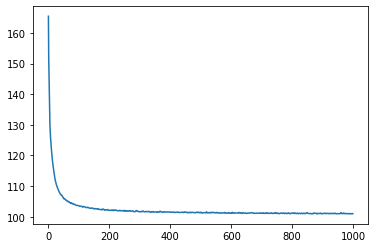

In [334]:
data = Dataset(X, Y)
model = LanguageModel(vocab_size, 50, vocab_size, n_layers=1, rnn=nn.GRU, bidirectional=False).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = get_optimizer(model, optimizer='adam', lr=0.01, weight_decay=0.0001)
model = train_language_model(data, model, opt, loss_fn, num_epochs=1000, batch_size=128, max_to_clip=5., 
                             test_data=data, print_every=1000//20)

In [335]:
idx = 1000
x = X[idx]
y = Y[idx]
yhat = model(x)
print(batch_to_text(x.argmax(dim=-1), itos).replace('<PAD>', ' '))
print(batch_to_text(yhat.argmax(dim=-1), itos).replace('<PAD>', ' '))

p a c h y s p o n d y l u s                        
h l h e e o o l o l l u r                          


In [ ]:
# improvements: use LSTMs or GRUs, multiple layers, Adam, LR scheduler, bidirectional RNNs
# it's overfitting pretty good when using a GRU with bidirectional
# the predictions still look pretty bad...no doubt due to batching and use of bidirectional

In [341]:
def predict(model, seed, max_len, output_len):
    tokens = pad([stoi[char.lower()] for char in seed], stoi['<PAD>'], max_len)
    for i in range(max_len - len(seed)):
        x = F.one_hot(torch.tensor(tokens)).float()
        yhat = model(x)
        probs = yhat.softmax(dim=-1).detach().numpy()[len(seed) + i]
        sample = stoi['<PAD>']
        if i > output_len:
            break
        while sample == stoi['<PAD>'] or sample == stoi['\n']:
            sample = np.random.choice(vocab_size, p=probs)
        tokens[len(seed) + i] = sample
    return tokens

seed = 'tyran'
tokens = predict(model, seed, max_len, 10)
batch_to_text(tokens, itos)

't y r a n o e p e s u s o s s s <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

# Embeddings

- Instead of one-hot encoding tokens, it's more efficient to feed their `stoi` index directly into the model via an embedding layer, which is a linear layer that takes an lookup index instead of a vector as input, and outputs a vector of specified size. 
- Mathematically, an embedding is a learned parameter matrix $E$ applied before the first layer of a neural net: $\sigma(WEx+b)$. 
- A given token is identified directly with its embedding vector as a representation of the token in a high-dimensional space. 
- When trained, these embeddings can learn semantic relationships between tokens, taking into account the context of the token to make predictions. 
- Embeddings can be used for unsupervised tasks, like similarity search or clustering of tokens and documents.
- Embeddings can be used to generate feature maps for text before feeding text into a supervised model. In this sense, embeddings enable transfer learning, where you can get away with training on less data with well-tuned embeddings.
- When working with text (or any categorical variable with large numbers of classes), an embedding layer should *always* be used.

In [4]:
vocab_size = 50
emb_size = 20

x = torch.randint(0, vocab_size, size=(10,))
emb = nn.Embedding(vocab_size, emb_size)
y = emb(x)
x.shape, y.shape

(torch.Size([10]), torch.Size([10, 20]))

## NLP Data Prep: Wikitext103

In [5]:
def text_from_iter(data_iter):
    corpus = []
    for text in data_iter:
        corpus.append(text)
    return corpus

train_iter = torchtext.datasets.WikiText103(split='train')
val_iter = torchtext.datasets.WikiText103(split='valid')
test_iter = torchtext.datasets.WikiText103(split='test')

train_text = text_from_iter(train_iter) + text_from_iter(val_iter)
test_text = text_from_iter(test_iter)
len(train_text), len(test_text)

(1805110, 4358)

In [6]:
# downsampling because this is way too much training data
fraction = round(len(train_text) * .08)
train_text = train_text[:fraction]
len(train_text)

144409

In [7]:
# def sub_special_tokens(text):
#     # put xxup token before words in all caps (easy way to recognize info from capitalizing a word)
#     text = re.sub(r'(\b[A-Z][A-Z0-9]*\b)', r' xxup \1 ', text)
#     # put xxcap token before words with capitalized first letter (easy way to recognize first word in a sentence)
#     text = re.sub(r'(\b[A-Z][a-z0-9]+\b)', r' xxcap \1 ', text)
#     # insert beginning and end of sentence tokens xxbos, xxeos after a period, at beginning, and strip extra xxbos
#     text = re.sub(r'( [.]+ )', r' xxeos \1 xxbos ', text)
#     text = ' xxbos ' + text
#     # text = text[:-7]
#     # insert beginning and end of document tokens xxbod, xxeod
#     text = ' xxbed ' + text + ' xxeod '
#     return text

# def normalize_text(text, remove_stopwords=False, stem_text=False, punct=None, lower=True, nums=None, 
#                    special_tokens=True, strip_non_ascii=False):
#     from nltk.stem import SnowballStemmer
#     from nltk.corpus import stopwords
#     import re, string

#     if text.strip() == '':
#         return ''
#     # strip new lines
#     text = re.sub(r'\n+','',text)
#     # put spaces between punctuation (eg: 9.Blah -> 9 . Blah)
#     puncts = r'[' + re.escape(string.punctuation) + r']'
#     text = re.sub('(?<! )(?=' + puncts + ')|(?<=' + puncts + ')(?! )', r' ', text)
#     # converts common patterns into special tokens
#     if special_tokens:
#         text = sub_special_tokens(text)
#     # convert text to lowercase
#     if lower:
#         text = text.lower()
#     # strip non-ascii characters (easy way to denoise text a bit)
#     if strip_non_ascii:
#         text = text.encode("ascii", errors="ignore").decode()
#     # replace all punctuation with xxpunct or strip depending on value of punct
#     if punct is not None:
#         text = re.sub(r"[^\w\s]",' xxpunct ', text) if punct == 'replace' else text
#         text = re.sub(r"[^\w\s]",'', text) if punct == 'strip' else text
#     # convert all other numbers to xxnum token (e.g. 123, 1.2.3, 1-2-3 -> xxnum)
#     if nums is not None:
#         text = re.sub(r'\b([.-]*[0-9]+[.-]*)+\b', ' xxnum ', text) if nums == 'replace' else text
#         text = re.sub(r'\b([.-]*[0-9]+[.-]*)+\b', '', text) if nums == 'strip' else text
#     # remove nltk's common set of stop words (common for classical NLP analysis)
#     if remove_stopwords:
#         stop_words = stopwords.words('english')
#         text = ' '.join(word for word in text.split() if word not in stop_words)
#     # stem words using nltk snowball stemmer, e.g. converts {run, running, runs} all to "run"
#     if stem_text:
#         stemmer = SnowballStemmer('english')
#         stemmed_text = ''
#         for word in text.split():
#                 stemmed_text = stemmed_text + stemmer.stem(word) + ' '
#         text = stemmed_text
#     # sub the occurance of 2 or more spaces with a single space
#     text = re.sub(r'[ ]{2,}',' ',text)
#     text = text.strip()
#     # fix messed up <unk> tokens
#     text = re.sub(r'unk','<unk>',text)       
#     return text

# def tokenize_corpus(corpus, normalizer, tokenizer, **kwargs):
#     tokens = []
#     for doc in tqdm(corpus):
#         doc = normalizer(doc, **kwargs)
#         doc = tokenizer(doc).text
#         toks = doc.split(' ') if (doc != '') else ['']
#         tokens.append(toks)
#     return tokens

# tokenizer = torchtext.data.utils.get_tokenizer(nlp) # spacy tokenizer as a function
# train_tokens = tokenize_corpus(train_text, normalize_text, tokenizer, punct='strip', nums='strip', strip_non_ascii=True, special_tokens=False)
# test_tokens = tokenize_corpus(test_text, normalize_text, tokenizer, punct='strip', nums='strip', strip_non_ascii=True, special_tokens=False)

In [8]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
train_tokens = (tokenizer(doc) for doc in tqdm(train_text))

vocab = torchtext.vocab.build_vocab_from_iterator(train_tokens, max_tokens=10000, specials=['<unk>', '<pad>'], min_freq=50)
vocab.set_default_index(vocab["<unk>"])
stoi = vocab.get_stoi()
itos = vocab.get_itos()
len(vocab)

  0%|          | 0/144409 [00:00<?, ?it/s]

9999

In [9]:
max_tokens = 256

train_tokens = (tokenizer(doc) for doc in tqdm(train_text))
test_tokens = (tokenizer(doc) for doc in tqdm(test_text))

train_tokens = [doc[:max_tokens] for doc in train_tokens if len(doc) > 5]
test_tokens = [doc[:max_tokens] for doc in test_tokens if len(doc) > 5]

  0%|          | 0/144409 [00:00<?, ?it/s]

  0%|          | 0/4358 [00:00<?, ?it/s]

## Word2Vec

- Continuous Bag of Words (CBOW): Predict target word given context words
- Skip-Gram: Predict some context word given the target word
- Model is $\hat y = \sigma(WEx+b)$, where $x, y, \hat y$ all have size $|V| \times m$.
- By default, embeddings have size 300. Vocab sizes can be size 10k or more.
- Due to the fact that the vocabulary $|V|$ can be very large, there are a large number of classes, which can make it impractical to calculate the softmax function. To get around this the authors use negative sampling. Instead of solving the original mapping problem, they create an equivalent task as follows:
    - For each context-target pair, a number $n$ of negative examples is created to pair with it. The same context is paired with a randomly sampled target, assumed to be false.
    - These context-target pairs are then fed into a binary classifier instead of a multiclass classifer, that tries to predict whether the pair is a valid pair or not.
- The paper also uses a "hierarchical softmax" function instead of the regular softmax, that uses a Huffman Tree to simplify the number of comparisons that need to be done when computing the function. In practice, this isn't really needed anymore with more modern frameworks.

In [10]:
# process text for word2vec CBOW
# X = context_window, y = target
# ex: 'the quick brown fox jumped' w/ window_size=2
# X = the quick _ fox jumped
# y = brown

def proc_for_word2vec(tokens, vocab, window_size=4, pad_token='<pad>'):
    contexts = []
    targets = []
    for doc in tqdm(tokens):
        doc = [pad_token] * window_size + doc + [pad_token] * window_size
        for i in range(window_size, len(doc) - window_size):
            context = doc[i - window_size: i] + doc[i + 1: i + window_size + 1]
            target = doc[i]
            # print(context, target)
            context = vocab(context)
            target = vocab([target])[0]
            contexts.append(context)
            targets.append(target)
    contexts = np.array(contexts, dtype=int)
    targets = np.array(targets, dtype=int)
    return contexts, targets

window_size = 5
X_train, y_train = proc_for_word2vec(train_tokens, vocab, window_size=window_size)
X_test, y_test = proc_for_word2vec(test_tokens, vocab, window_size=window_size)

  0%|          | 0/83169 [00:00<?, ?it/s]

  0%|          | 0/2531 [00:00<?, ?it/s]

In [11]:
X_train = torch.from_numpy(X_train).long().to(device)
X_test = torch.from_numpy(X_test).long().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
y_test = torch.from_numpy(y_test).long().to(device)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([7807669, 10]),
 torch.Size([7807669]),
 torch.Size([235160, 10]),
 torch.Size([235160]))

In [12]:
train_data = Dataset(X_train, y_train)
test_data = Dataset(X_test, y_test)

In [13]:
for idx in np.random.choice(len(test_data), size=5):
    context = [itos[i] for i in X_train[idx].cpu()]
    target = itos[y_train[idx]]
    print(f'context: {context} \n target: {target} \n\n')

context: ['for', 'the', 'blue', 'jackets', 'in', 'second', 'game', ',', 'a', '4'] 
 target: his 


context: ['performed', 'under', 'contract', 'throughout', 'europe', 'at', 'times', 'for', 'heads', 'of'] 
 target: and 


context: ['and', '<unk>', 'a', 'range', 'of', 'sports', ',', 'such', 'as', 'racing'] 
 target: air 


context: ['.', '@', '89', 'miles', '(', '@', '.', '@', '04', 'km'] 
 target: 3 


context: ['<pad>', 'the', 're', '@-@', 'recorded', 'of', 'west', 'end', 'girls', 'was'] 
 target: version 




In [14]:
vocab_size = len(vocab)
emb_size = 300

class Word2VecCBOW(nn.Module):
    def __init__(self, window_size, vocab_size, emb_size=300):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_size, max_norm=1)
        self.fc = nn.Linear(emb_size, vocab_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # pass each x[0, ..., context_window] through self.emb
        x = self.emb(x)
        # average the context_window outputs together to get an emb_size vector
        x = torch.mean(x, dim=1)
        # extra layers
        x = self.relu(x)
        # pass vector through linear layer to get vocab_size logits
        x = self.fc(x)
        # return logits
        return x

In [15]:
# model = Word2VecCBOW(window_size, vocab_size, emb_size=emb_size).to(device)
# loss_fn = nn.CrossEntropyLoss()
# opt = get_optimizer(model, optimizer='adam', lr=0.004, weight_decay=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
# model = train_model(train_data, model, opt, loss_fn, num_epochs=100, batch_size=4096, test_data=test_data,
#                     scheduler=scheduler, print_every=5)

In [16]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4096, shuffle=False)
dls = fastai.DataLoaders(train_loader, test_loader)

model = Word2VecCBOW(window_size, vocab_size, emb_size=emb_size).to(device)
loss_fn = nn.CrossEntropyLoss()

SuggestedLRs(valley=0.004365158267319202)

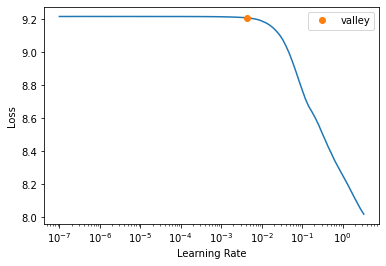

In [17]:
learn = Learner(dls, model, loss_func=loss_fn, metrics=fastai.accuracy)
learn.lr_find()

In [18]:
learn.fit_one_cycle(15, 0.004)

epoch,train_loss,valid_loss,accuracy,time
0,6.229568,6.124390,0.110941,03:41
1,5.878863,5.761906,0.162162,03:45
2,5.676596,5.578877,0.175370,03:52
3,5.574441,5.474500,0.181200,03:54
4,5.509526,5.413337,0.182973,03:57
5,5.452353,5.361015,0.186473,03:57
6,5.396221,5.314703,0.190458,03:57
7,5.372440,5.283380,0.191959,03:58
8,5.336491,5.253022,0.194701,04:00
9,5.301993,5.226168,0.197776,04:00


In [19]:
checkpoint = Path.cwd() / 'models' / 'checkpoint.pth'

In [20]:
model = learn.model
torch.save(model.state_dict(), checkpoint)

In [21]:
model = Word2VecCBOW(window_size, vocab_size, emb_size=emb_size).to(device)
model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

In [22]:
model = model.eval()
embeddings = model.emb

In [23]:
def word_embedding(word, embeddings, stoi):
    x = torch.tensor(stoi[word]).long().to(device)
    x = embeddings(x)
    return x

queen = word_embedding('queen', embeddings, stoi)
king = word_embedding('king', embeddings, stoi)
woman = word_embedding('woman', embeddings, stoi)
man = word_embedding('man', embeddings, stoi)

In [24]:
F.cosine_similarity(king - man + woman, queen, dim=0)

tensor(0.8209, device='cuda:0', grad_fn=<DivBackward0>)

In [25]:
def most_similar_words(word, embeddings, stoi, itos, n_most=10):
    if isinstance(word, str):
        word = word_embedding(word, embeddings, stoi)[None, :]
    embs = list(embeddings.parameters())[0].detach()
    sims = F.cosine_similarity(word, embs, dim=1).detach().cpu()
    top_n = torch.topk(torch.abs(sims), n_most, largest=False, sorted=True).indices
    return [(itos[idx], sims[idx].numpy().item()) for idx in top_n]

In [26]:
most_similar_words('king', embeddings, stoi, itos, n_most=10)

[('integral', -2.872199047487811e-06),
 ('phylogenetic', -9.573996976541821e-06),
 ('usually', -9.017906995723024e-05),
 ('health', -0.0001353882544208318),
 ('stronger', 0.0001357515575364232),
 ('filmed', 0.00018133968114852905),
 ('flags', -0.00019406157662160695),
 ('rented', -0.00020855292677879333),
 ('laser', -0.00021361563995014876),
 ('environments', 0.00021713320165872574)]

In [27]:
most_similar_words(king - man + woman, embeddings, stoi, itos, n_most=10)

[('320', 1.5628698747605085e-05),
 ('140', -9.740883979247883e-05),
 ('busy', 9.890575893223286e-05),
 ('results', 0.00011465771240182221),
 ('03', 0.0001278647978324443),
 ('folded', -0.0001308945647906512),
 ('0000', -0.0001319859438808635),
 ('doubles', -0.00020721058535855263),
 ('effect', -0.00023616498219780624),
 ('stunt', 0.0002486630401108414)]

In [28]:
def predict(context, model, stoi, itos, top_k=5):
    x = torch.tensor([stoi[word] for word in context]).long().to(device)
    yhat = model(x[None, :]).detach().cpu().flatten()
    idxs = torch.topk(yhat, top_k, largest=True, sorted=True).indices.flatten()
    preds = [(itos[idx], yhat.softmax(dim=0)[idx].numpy().item()) for idx in idxs]
    return preds

context = ['controversial', 'strike', 'call', 'made', 'by', 'plate', 'umpire', '<unk>', 'foster', '.']
target = 'home'
pred = predict(context, model, stoi, itos, top_k=10)
' '.join(context), target, pred

('controversial strike call made by plate umpire <unk> foster .',
 'home',
 [('a', 0.23952102661132812),
  ('the', 0.22333352267742157),
  ('<unk>', 0.04164113476872444),
  ('to', 0.041029222309589386),
  ('an', 0.037046175450086594),
  ('and', 0.03352990001440048),
  ('was', 0.03270604461431503),
  ('his', 0.027243968099355698),
  (',', 0.019775737076997757),
  ('@-@', 0.011665976606309414)])

## GloVe

- Slightly different way of learning word embeddings from word2vec
- Given a corpus and vocabular, it uses the co-ocurrance $X=(x_{ij})$, where $x_{ij}$ is the number of times word $j$ occurs in the context of word $i$.
- Given some weighting function $f(x_{ij})$ it seeks to solve the following optimization problem
$$\text{min} \sum_{i,j=1}^{|V|} f(x_{ij}) (\tilde e_j^T e_i + b_i + \tilde b_j - \log(x_{ij}))^2$$,
where $e, \tilde e, b, \tilde b$ are parameter matrices and vectors to be learned
- Note $e$ and $\tilde e$ are both embedding matrices, but aren't exactly equal. To get the final embeddings $E$, just take the average of the two: $E = \frac{1}{2}(e + \tilde e)$.

In [124]:
# get co-occurance matrix X_ij = num times word j appears in context of target word i

def cooccurance_matrix(corpus, vocab, window_size=4, pad_token='<pad>'):
    vocab_size = len(vocab)
    X = torch.zeros((vocab_size, vocab_size))
    for doc in tqdm(corpus):
        doc_padded = [pad_token] * window_size + doc + [pad_token] * window_size
        nums = vocab(doc_padded)
        for k in range(len(nums)):
            i = nums[k]
            js = nums[k - window_size: k + window_size + 1]
            for j in js:
                X[i, j] += 1
    return X

class GloveLoss(nn.Module):
    def __init__(self, vocab_size, emb_size, eps=1e-8):
        super().__init__()
        self.e1 = nn.parameter.Parameter(2 * torch.rand(vocab_size, emb_size) - 1, requires_grad=True)
        self.e2 = nn.parameter.Parameter(2 * torch.rand(vocab_size, emb_size) - 1, requires_grad=True)
        self.b = nn.parameter.Parameter(torch.zeros(vocab_size, 1), requires_grad=True)
        self.eps = eps
    
    def forward(self, X):
        mask = (self.e1 @ self.e2.T + self.b - torch.log(X))[X > self.eps]
        loss = torch.sum(mask**2)
        return loss

In [111]:
test = ['this is a sentence about nothing .'.split(), 'this is another sentence about absolutely nothing .'.split()]
x = cooccurance_matrix(test, vocab, window_size=4, pad_token='<pad>')
test, x[stoi['this'], stoi['is']]

  0%|          | 0/2 [00:00<?, ?it/s]

([['this', 'is', 'a', 'sentence', 'about', 'nothing', '.'],
  ['this',
   'is',
   'another',
   'sentence',
   'about',
   'absolutely',
   'nothing',
   '.']],
 tensor(2.))

In [14]:
X_train = cooccurance_matrix(train_tokens, vocab, window_size=4, pad_token='<pad>')
X_test = cooccurance_matrix(test_tokens, vocab, window_size=4, pad_token='<pad>')

  0%|          | 0/83169 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [125]:
X_train = X_train.to(device)
X_test = X_test.to(device)

In [126]:
vocab_size = len(vocab)
emb_size = 300

In [149]:
n_iters = 10000
loss_fn = GloveLoss(vocab_size, emb_size).to(device)
opt = get_optimizer(loss_fn, optimizer='adam', lr=0.1, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2000, gamma=0.5)
for n in tqdm(range(n_iters+1)):
    opt.zero_grad()
    loss = loss_fn(X_train)
    loss.backward()
    opt.step()
    scheduler.step()
    if n % (n_iters // 10) == 0:
        train_loss = loss.detach().cpu().numpy().item()
        test_loss = loss_fn(X_test).detach().cpu().numpy().item()
        print(f'iter: {n} \t\t train loss: {round(train_loss)} \t\t test loss: {round(test_loss)}')

  0%|          | 0/10001 [00:00<?, ?it/s]

iter: 0 		 train loss: 230594272 		 test loss: 9598362
iter: 1000 		 train loss: 187467 		 test loss: 3008212
iter: 2000 		 train loss: 175377 		 test loss: 3143044
iter: 3000 		 train loss: 163996 		 test loss: 3246573
iter: 4000 		 train loss: 161332 		 test loss: 3325470
iter: 5000 		 train loss: 158753 		 test loss: 3412328
iter: 6000 		 train loss: 157538 		 test loss: 3457867
iter: 7000 		 train loss: 156356 		 test loss: 3520260
iter: 8000 		 train loss: 155695 		 test loss: 3574653
iter: 9000 		 train loss: 154995 		 test loss: 3618994
iter: 10000 		 train loss: 154494 		 test loss: 3665514


In [150]:
# check these are the updated params first
embeddings = (loss_fn.e1 + loss_fn.e2) / 2
embeddings.shape

torch.Size([9999, 300])

In [151]:
def word_embedding(word, embeddings, stoi):
    x = torch.tensor(stoi[word]).long().to(device)
    x = embeddings[x]
    return x

def most_similar_words(word, embeddings, stoi, itos, n_most=10):
    if isinstance(word, str):
        word = word_embedding(word, embeddings, stoi)[None, :]
    embs = embeddings.detach()
    sims = F.cosine_similarity(word, embs, dim=1).detach().cpu()
    top_n = torch.topk(torch.abs(sims), n_most, largest=False, sorted=True).indices
    return [(itos[idx], sims[idx].numpy().item()) for idx in top_n]

In [152]:
queen = word_embedding('queen', embeddings, stoi)
king = word_embedding('king', embeddings, stoi)
woman = word_embedding('woman', embeddings, stoi)
man = word_embedding('man', embeddings, stoi)
F.cosine_similarity(king - man + woman, queen, dim=0)

tensor(0.3064, device='cuda:0', grad_fn=<DivBackward0>)

In [159]:
most_similar_words('physics', embeddings, stoi, itos, n_most=20)

[('celebrate', 9.375954505230766e-06),
 ('1920', 2.9976708901813254e-05),
 ('solving', -3.0787054129177704e-05),
 ('ships', -3.7333793443394825e-05),
 ('resigned', -3.9224167267093435e-05),
 ('near', -4.626500958693214e-05),
 ('accompanying', -5.384801625041291e-05),
 ('syndrome', -6.074453267501667e-05),
 ('490', 8.769206033321097e-05),
 ('contained', 9.128214878728613e-05),
 ('composers', 9.754366328706965e-05),
 ('package', 0.00011003619147231802),
 ('castle', -0.00012274799519218504),
 ('epidemic', -0.00012277578935027122),
 ('understood', 0.0001257588155567646),
 ('adam', 0.0001278083655051887),
 ('brass', 0.00015247093688230962),
 ('hundreds', -0.00015269142750184983),
 ('proposals', -0.000157077782205306),
 ('′', -0.0001716559345368296)]

# Advanced Model Architectures

**Seq2Seq Models**
- Maps a sequence $x_1,\cdots,x_T$ to a new sequence $y_1,\cdots,y_{T'}$.
- The stereotypical application is machine translation, where text in one language is translated to language in another language, e.g. `I am going home.` -> `Ich gehe nacht Hause.`. Other examples include named entity recognition (NER), part of speech tagging (POS), or speech recognition (audio to text).
- Typically an encoder-decoder architecture is used. The encoder is a sequence model (e.g. an RNN) that takes a sequence and maps it to an intermediate representation, which then gets fed to a decoder, which is a different sequence model that maps representations to the output sequence.

**Image to Text Models**
- Maps an image to a sequence of text output. The stereotypical example is image captioning, where one feeds in an image and asks the model to "describe" what the image is in words.
- Typically a CNN model is used to get a feature map of the image, which is then fed as an input into a sequence model decoder to output text.

**Beam Search**
- In a seq2seq model, the model tries to learn $p(y_1,\cdots,y_{T'}|x_1,\cdots,x_T)$. In many applications, one doesn't want to sample from this distribution, but to find the *most likely* sequence $\hat y_1, \cdots, \hat y_{T'}$, e.g. in machine translation where one wants the *best* possible translation.
- The naive way of outputing a prediction is a "greedy search". This approach just uses the argmax of each predicted $\hat y_t$ to make a prediction. Greedy searches aren't generally optimal, in the sense of getting the argmax of the *joint distribution*. In the case of seq2seq, the greedy search can overly focus on the earlier inputs, causing it to miss the big picture.
- Beam search is a way around this. It's an approximate algorithm for finding the max of a set of sequences sampled from a joint distribution, i.e. finding $\hat y = \text{argmax} p(y_1,\cdots,y_{T'}|x_1,\cdots,x_T)$.

**Attention Models**

In [ ]:
torch.random.